# MNIST Classification

In [1]:
import os
import sys

In [2]:
sys.path.append(
    os.path.dirname(os.path.abspath(''))
)

## Data

In [3]:
from sklearn.datasets import fetch_openml
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from utils.plots import plot_digit

### Get the Data

In [4]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


### View the Data

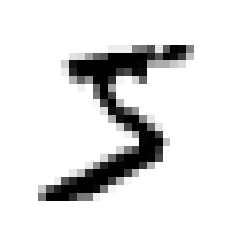

In [6]:
some_digit = X.iloc[0]
plot_digit(some_digit.values)
plt.show()

In [7]:
y[0]

'5'

In [8]:
y = y.astype(np.uint8)

### Split train and test

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Binary Classifier

In [10]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from classifiers.Never5Classifier import Never5Classifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from utils.plots import plot_precision_recall_vs_threshold, plot_precision_vs_recall
from sklearn.metrics import roc_curve
from utils.plots import plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [11]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

### Stochastic Gradient Decent

#### Train

In [12]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [13]:
sgd_clf.predict([some_digit])

array([ True])

### Evaluate

#### Accuracy

In [14]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

#### Confusion Matrix

In [16]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [17]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [18]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

#### precision and recall

In [19]:
print(f'precision: {precision_score(y_train_5, y_train_pred)}')
print(f'recall: {recall_score(y_train_5, y_train_pred)}')

precision: 0.8370879772350012
recall: 0.6511713705958311


In [20]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [21]:
y_scores = sgd_clf.decision_function([some_digit])
print(f'y score = {y_scores}')
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

y score = [2164.22030239]
[ True]


In [22]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [23]:
y_scores = cross_val_predict(
    sgd_clf, X_train, y_train_5, cv=3 ,
    method='decision_function'
)

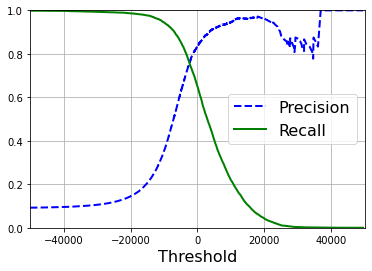

In [24]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

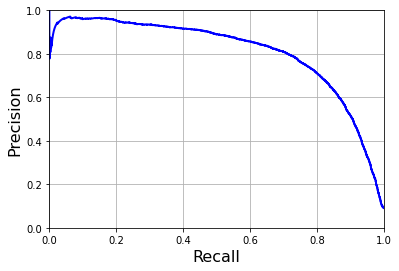

In [25]:
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [26]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.019499143958

In [27]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [28]:
print(f'precision: {precision_score(y_train_5, y_train_pred_90)}')
print(f'recall: {recall_score(y_train_5, y_train_pred_90)}')

precision: 0.9000345901072293
recall: 0.4799852425751706


#### ROC Curve

In [29]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

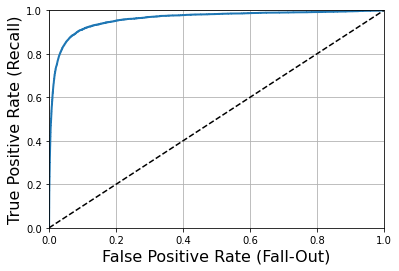

In [30]:
plot_roc_curve(fpr, tpr)
plt.show()

In [31]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### Random Forest Classifier

In [32]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(
    forest_clf, X_train, y_train_5, cv=3,
    method='predict_proba'
)

In [33]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

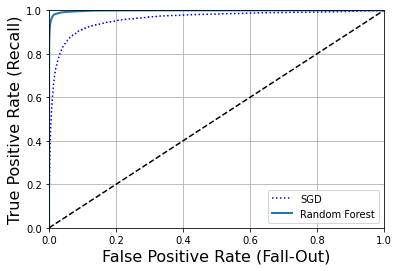

In [34]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [35]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## Multiclass Classification

In [36]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler

### OvO SVM

In [37]:
svm_clf = SVC()
svm_clf.fit(X_train, y_train)

SVC()

In [38]:
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [39]:
some_digit_score = svm_clf.decision_function([some_digit])
some_digit_score

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [40]:
print(f'index: {np.argmax(some_digit_score)}')
print(svm_clf.classes_)
print(svm_clf.classes_[5])

index: 5
[0 1 2 3 4 5 6 7 8 9]
5


### OvR SVM

In [41]:
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [42]:
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [43]:
len(ovr_clf.estimators_)

10

### SGD

In [44]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [45]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [46]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

## Error Analysis

In [47]:
from utils.plots import plot_digits

In [48]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [49]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

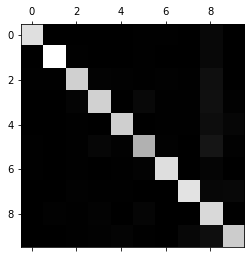

In [50]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [51]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

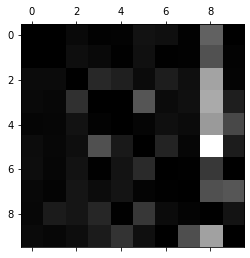

In [52]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

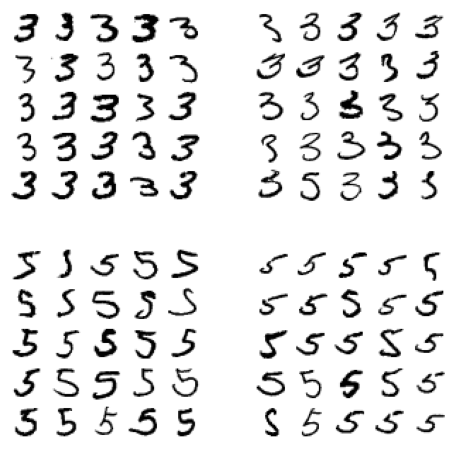

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
from utils.plots import plot_digits

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

# X_aa = pd.read_csv('X_aa.csv')
# X_ab = pd.read_csv('X_ab.csv')
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25].values, images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25].values, images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25].values, images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25].values, images_per_row=5)
plt.show()

In [54]:
a = X_aa.iloc[:25].values
# plot_digits(a, images_per_row=5
X_ab.to_csv('X_ab.csv', index=False)

In [55]:
%pwd

'/home/amirali/Codes/learning things/Hands-on machine learning/Hands-on-ML/Chapter3'

## Multilabel Classification

In [56]:
from sklearn.neighbors import KNeighborsClassifier

In [57]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [58]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [59]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [60]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

## Multioutput Classification

In [72]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

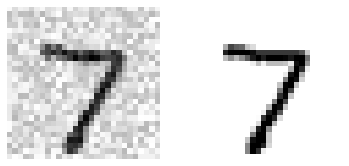

In [78]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod.values[some_index])
plt.subplot(122); plot_digit(y_test_mod.values[some_index])
plt.show()

In [79]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

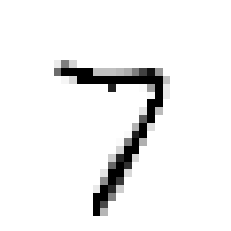

In [81]:
clean_digit = knn_clf.predict([X_test_mod.values[some_index]])
plot_digit(clean_digit)
